# Description

The goal of the notebook is to measure the effect on DAG execution time from using a shorter history lookback period.

Compare the results: history lookback is 4 days vs history lookback is 15 minutes.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging

import pandas as pd

import dataflow.core as dtfcore
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import reconciliation as reconcil

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-fb20a37b-d63b-4fba-869a-f1630ea53b24.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4240_tweak_history_lookback_2'
  hash='f8f21a6c3'
  # Last commits:
    * f8f21a6c3 PomazkinG checkpoint                                                        (   3 hours ago) Mon Apr 17 17:47:00 2023  (HEAD -> CmTask4240_tweak_history_lookback_2, origin/CmTask4240_tweak_history_lookback, CmTask4240_tweak_history_lookback)
    * 464e5e50e PomazkinG checkpoint                                                        (   

# Specify the paths

In [4]:
system_log_path_dict = {
    "lookback_4_days": "/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230413/system_log_dir.scheduled.20230413_143500.20230413_203000",
    "lookback_15_minutes": "/shared_data/system_log_dir_20230417_lookback_experiment",
}
system_log_path_dict

{'lookback_4_days': '/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230413/system_log_dir.scheduled.20230413_143500.20230413_203000',
 'lookback_15_minutes': '/shared_data/system_log_dir_20230417_lookback_experiment'}

In [5]:
data_type = "dag_data"
dag_path_dict = {
    "lookback_4_days": reconcil.get_data_type_system_log_path(
        system_log_path_dict["lookback_4_days"], data_type
    ),
    "lookback_15_minutes": reconcil.get_data_type_system_log_path(
        system_log_path_dict["lookback_15_minutes"], data_type
    ),
}
dag_path_dict

{'lookback_4_days': '/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230413/system_log_dir.scheduled.20230413_143500.20230413_203000/dag/node_io/node_io.data',
 'lookback_15_minutes': '/shared_data/system_log_dir_20230417_lookback_experiment/dag/node_io/node_io.data'}

# Compare DAG execution time

In [6]:
df_dag_execution_time_4_days = dtfcore.get_execution_time_for_all_dag_nodes(
    dag_path_dict["lookback_4_days"]
)
df_dag_execution_time_15_minutes = dtfcore.get_execution_time_for_all_dag_nodes(
    dag_path_dict["lookback_15_minutes"]
)

,mean,min,max,std
all_nodes,23.781139,22.381,25.029,0.55607
read_data,8.483569,7.838,9.362,0.294276
,...,...,...,...
generate_feature,2.318347,2.178,2.456,0.06941
process_forecasts,2.288931,2.155,2.41,0.066356


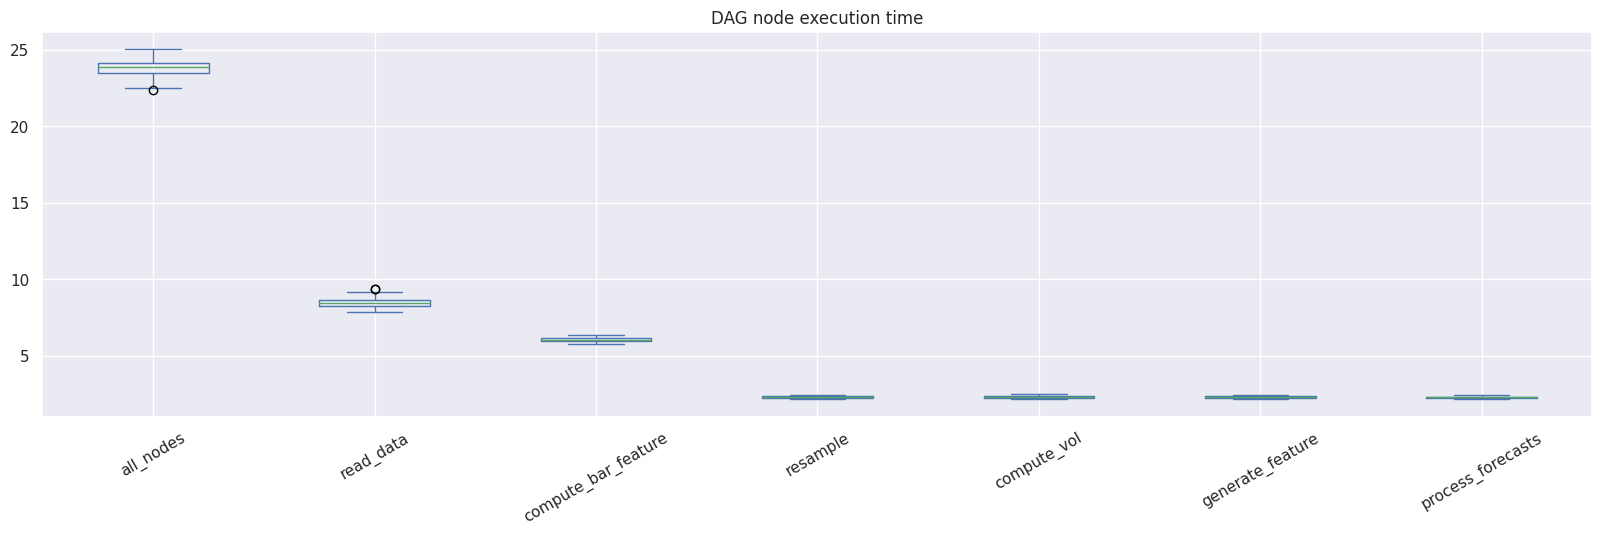

In [7]:
dtfcore.plot_dag_execution_stats(df_dag_execution_time_4_days, report_stats=True)

,mean,min,max,std
all_nodes,12.4922,12.007,12.859,0.340047
read_data,1.2692,1.209,1.329,0.058058
,...,...,...,...
generate_feature,1.9222,1.818,2.003,0.067696
process_forecasts,1.8588,1.772,1.912,0.056756


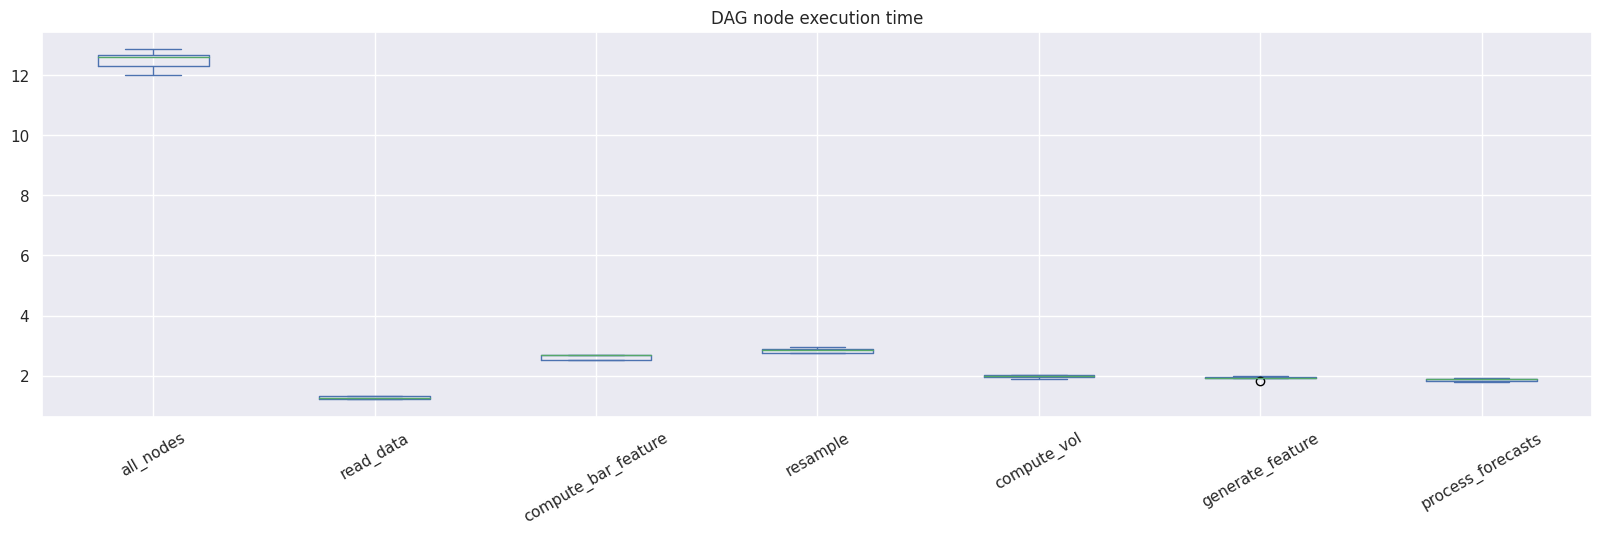

In [8]:
dtfcore.plot_dag_execution_stats(
    df_dag_execution_time_15_minutes, report_stats=True
)

# Sanity check the DAG node output size

In [9]:
read_data_node = "predict.0.read_data"
resample_node = "predict.2.resample"
timestamp_lookback_15_minutes = pd.Timestamp("2023-04-17 10:35:00")
timestamp_lookback_lookback_4_days = pd.Timestamp("2023-04-13 10:35:00")

In [10]:
read_data_4_days = dtfcore.get_dag_node_output(
    dag_path_dict["lookback_4_days"],
    read_data_node,
    timestamp_lookback_lookback_4_days,
)
_LOG.info(
    "The df size is %s rows x %s columns",
    read_data_4_days.shape[0],
    read_data_4_days.shape[1],
)

INFO  The df size is 5760 rows x 250 columns


In [11]:
read_data_15_minutes = dtfcore.get_dag_node_output(
    dag_path_dict["lookback_15_minutes"],
    read_data_node,
    timestamp_lookback_15_minutes,
)
_LOG.info(
    "The df size is %s rows x %s columns",
    read_data_15_minutes.shape[0],
    read_data_15_minutes.shape[1],
)

INFO  The df size is 15 rows x 250 columns


In [12]:
resample_4_days = dtfcore.get_dag_node_output(
    dag_path_dict["lookback_4_days"],
    resample_node,
    timestamp_lookback_lookback_4_days,
)
_LOG.info(
    "The df size is %s rows x %s columns",
    resample_4_days.shape[0],
    resample_4_days.shape[1],
)

INFO  The df size is 1152 rows x 200 columns


In [13]:
resample_15_minutes = dtfcore.get_dag_node_output(
    dag_path_dict["lookback_15_minutes"],
    resample_node,
    timestamp_lookback_15_minutes,
)
_LOG.info(
    "The df size is %s rows x %s columns",
    resample_15_minutes.shape[0],
    resample_15_minutes.shape[1],
)

INFO  The df size is 3 rows x 200 columns
